In [1]:
import numpy as np
# from rtc_seq_dataset import SeqDistDataset, open_rtc_table
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import pandas as pd
import geopandas as gpd
import importlib

# Data Stuff

In [2]:
df_burst = gpd.read_parquet('validation_bursts_v1_coverage_updated.parquet')
df_burst = df_burst.drop_duplicates(subset='jpl_burst_id').reset_index(drop=True)
df_burst.shape

(105, 4)

In [3]:
df_burst.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T005-008692-IW2,"POLYGON ((-97.21446 17.86505, -97.21446 17.864...",104,72
1,T008-015865-IW2,"POLYGON ((-1.50129 41.44183, -1.50130 41.44156...",101,150
2,T012-024584-IW1,"POLYGON ((-103.78409 20.20832, -103.78409 20.2...",101,34
3,T014-028130-IW2,"POLYGON ((37.01648 35.59545, 37.01649 35.59518...",100,22
4,T014-028131-IW2,"POLYGON ((36.98085 35.76145, 36.98085 35.76118...",38,22


In [4]:
START_INDEX = 0
TOTAL_BURSTS = 105

In [5]:
df_burst_subset = df_burst.iloc[START_INDEX:START_INDEX + TOTAL_BURSTS].reset_index(drop=True)
df_burst_subset.head()

,jpl_burst_id,geometry,n_acquisitions,site_id
0,T005-008692-IW2,"POLYGON ((-97.21446 17.86505, -97.21446 17.864...",104,72
1,T008-015865-IW2,"POLYGON ((-1.50129 41.44183, -1.50130 41.44156...",101,150
2,T012-024584-IW1,"POLYGON ((-103.78409 20.20832, -103.78409 20.2...",101,34
3,T014-028130-IW2,"POLYGON ((37.01648 35.59545, 37.01649 35.59518...",100,22
4,T014-028131-IW2,"POLYGON ((36.98085 35.76145, 36.98085 35.76118...",38,22


In [6]:
df_burst_subset.shape

(105, 4)

In [7]:
total_files = df_burst_subset.n_acquisitions.sum()
f'Approx files will be {total_files * 30 / 1e3} GB (total_files: {total_files})'

'Approx files will be 294.45 GB (total_files: 9815)'

In [8]:
df_rtc = pd.read_json('rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [9]:
df_rtc_subset = pd.merge(df_rtc, df_burst_subset[['jpl_burst_id']], how='inner', on='jpl_burst_id').reset_index(drop=True)
df_rtc_subset.sort_values(by=['jpl_burst_id', 'rtc_s1_id'], inplace=True, ascending=True)
df_rtc_subset.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008692-IW2_20201004T00392...,S1B_IW_SLC__1SDV_20201004T003926_20201004T0039...,T005-008692-IW2,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-04 00:39:26
1,OPERA_L2_RTC-S1_T005-008692-IW2_20201010T00401...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008692-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
2,OPERA_L2_RTC-S1_T005-008692-IW2_20201016T00393...,S1B_IW_SLC__1SDV_20201016T003926_20201016T0039...,T005-008692-IW2,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-16 00:39:26
3,OPERA_L2_RTC-S1_T005-008692-IW2_20201022T00401...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008692-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
4,OPERA_L2_RTC-S1_T005-008692-IW2_20201028T00393...,S1B_IW_SLC__1SDV_20201028T003926_20201028T0039...,T005-008692-IW2,28,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-28 00:39:26


In [10]:
df_rtc_subset.shape


(9815, 8)

In [11]:
df_rtc_subset.to_parquet('rtc_data_subset.parquet')

In [12]:
num_pre_imgs = 10

In [13]:
from rtc_seq_dataset_stream import SeqDistDatasetStreamPatches, open_rtc_table

df_rtc = open_rtc_table()

In [14]:

import rtc_seq_dataset

importlib.reload(rtc_seq_dataset)

<module 'rtc_seq_dataset' from '/mnt/aurora-r0/jungkyo/OPERA/DIST-S1/algorithms/dist-s1-model/rtc_seq_dataset.py'>

In [15]:
from rtc_seq_dataset import SeqDistDataset, open_rtc_table

In [16]:
seq_dataset = SeqDistDataset(n_pre_imgs=10,
                             root='test_data/',
                             n_workers_for_download = 4,
                             patch_size= 224,
                             rtc_s1_parquet_table_path='rtc_data_subset.parquet', #have to update this for given burst range
                            )

localize patch tables: 100%|███████████████████████████████████| 105/105 [00:00<00:00, 31410.16it/s]


Test

In [17]:
seq_dataset.__len__()

1281287

1119452


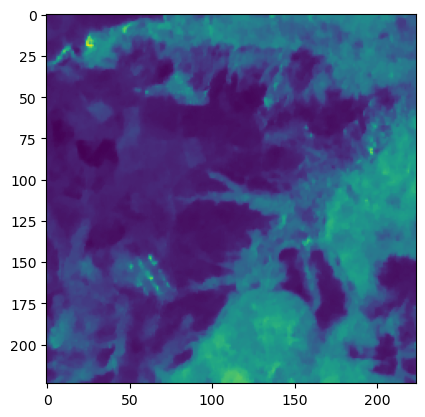

In [18]:
import matplotlib.pyplot as plt
index = np.random.randint(len(seq_dataset))
print(index)

plt.imshow(seq_dataset[index]["post_img"][0,:,:])
# plt.imshow(seq_dataset[index]["post_img"][1,:,:])

In [19]:
dataloader = DataLoader(seq_dataset, batch_size=32, shuffle=True)
print(len(dataloader))

40041


### Various storage experiments

In [20]:
for i, data in enumerate(dataloader):
    train_data = data["pre_imgs"]
    target = data["post_img"]
    print(train_data.shape)
    print(target.shape)
    break

torch.Size([32, 10, 2, 224, 224])
torch.Size([32, 2, 224, 224])


In [21]:
dataset_of_128 = torch.utils.data.TensorDataset(train_data, target)

In [22]:
import os
os.makedirs('PytorchData', exist_ok=True)
torch.save(dataset_of_128, "PytorchData/how_much_space_is_this_128.pt")

In [23]:

hmm = torch.load("PytorchData/how_much_space_is_this_128.pt")

# Transformer

In [24]:
import numpy as np
from torch.utils.data import DataLoader, random_split, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Subset, ConcatDataset
import time
import random
from IPython.display import HTML
from utils import log_ratio, visualize_reconstruction, animate_data, nll_gaussian, nll_gaussian_stable
import einops


### New stuff

In [25]:
class SpatioTemporalTransformer(nn.Module):
    def __init__(self, model_config):
        super(SpatioTemporalTransformer, self).__init__()

        # self.data_dim = model_config['data_dim'] # dim of patches
        self.d_model = model_config['d_model']
        self.nhead = model_config['nhead']
        self.num_encoder_layers = model_config['num_encoder_layers']
        self.dim_feedforward = model_config['dim_feedforward']
        self.max_seq_len = model_config['max_seq_len']
        self.dropout = model_config['dropout']
        self.activation = model_config['activation']

        self.num_patches = model_config['num_patches']
        self.patch_size = model_config['patch_size']
        self.data_dim = model_config['data_dim']

        self.embedding = nn.Linear(self.data_dim, self.d_model)

        self.spatial_pos_embed = nn.Parameter(torch.zeros(1, 1, self.num_patches, self.d_model))
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, self.max_seq_len, 1, self.d_model))

        #we use 'encoder' for simplicity - but equivalent to the "Decoder only" framework
        encoder_layer = nn.TransformerEncoderLayer(
            self.d_model, self.nhead, self.dim_feedforward, dropout=self.dropout, activation=self.activation, batch_first=True
            )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, self.num_encoder_layers)

        self.mean_out = nn.Sequential(
            nn.Linear(self.d_model, self.dim_feedforward), #reuse dim feedforward here
            nn.ReLU(),
            nn.Linear(self.dim_feedforward, self.data_dim)
        )

        self.logvar_out = nn.Sequential(
            nn.Linear(self.d_model, self.dim_feedforward), #reuse dim feedforward here
            nn.ReLU(),
            nn.Linear(self.dim_feedforward, self.data_dim)
        )

    def num_parameters(self):
        """Count the number of trainable parameters in the model."""
        if not hasattr(self, '_num_parameters'):
            self._num_parameters = 0
            for p in self.parameters():
                count = 1
                for s in p.size():
                    count *= s
                self._num_parameters += count

        return self._num_parameters

    def forward(self, src):

        batch_size, seq_len, channels, height, width = src.shape

        assert num_patches == (height*width) / (self.patch_size**2)
        assert seq_len <= self.max_seq_len

        src = einops.rearrange(src, 'b t c (h ph) (w pw) -> b t (h w) (c ph pw)', ph=self.patch_size, pw=self.patch_size) # batch, seq_len, num_patches, data_dim

        # after this line, the shape will be batch, seq_len, num_patches, d_model
        # the indexing on temporal_pos_embed is in case the input is less than max_seq_len
        src = self.embedding(src) + self.spatial_pos_embed + self.temporal_pos_embed[:, (self.max_seq_len-seq_len):, :, :] 

        src = src.view(batch_size, seq_len * self.num_patches, self.d_model) # transformer expects (batch_size, sequence, dmodel)

        # Pass through the transformer encoder with causal masking
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(src.device)
        # mask = mask.repeat(self.num_patches, self.num_patches)
        mask = mask.repeat_interleave(num_patches, dim=0).repeat_interleave(num_patches, dim=1)

        output = self.transformer_encoder(src, mask=mask)

        mean = self.mean_out(output) # batchsize, seq_len*num_patches, data_dim
        logvar = self.logvar_out(output) # batchsize, seq_len*num_patches, data_dim

        mean = mean.view(batch_size, seq_len, self.num_patches, self.data_dim) #undo previous operation
        logvar = logvar.view(batch_size, seq_len, self.num_patches, self.data_dim)

        # reshape to be the same shape as input batch_size, seq len, channels, height, width
        mean = einops.rearrange(mean, 'b t (h w) (c ph pw) -> b t c (h ph) (w pw)',
                                ph=self.patch_size, pw=self.patch_size,c=channels, h=height//patch_size, w=width//patch_size)

        logvar = einops.rearrange(logvar, 'b t (h w) (c ph pw) -> b t c (h ph) (w pw)',
                                ph=self.patch_size, pw=self.patch_size,c=channels, h=height//patch_size, w=width//patch_size)

        return mean, logvar

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [27]:
import time

# this line is slow for some reason and we need it every loss so we construct it once to start
pi = torch.FloatTensor([np.pi]).to(device)

def run_epoch(dataloader, model, optimizer, device, train=True):
    """Perform one epoch of training by looping through the dataset once."""

    '''
    dataloader should have:
    pre_imgs: (batch_size, max_seq_len, channels, height, width)
    target: (batch_size, channels, height, width)
    '''

    # Setting models and datasets into train/test mode
    if train:
        model.train()
    else:
        model.eval()

    nll_total = 0
    mse_total = 0

    naive_nll = 0
    naive_mse = 0

    for batch_idx, (batch,target) in enumerate(dataloader):

        input_size = 16
        
        batch = batch.unfold(3, input_size, input_size).unfold(4, input_size, input_size)
        target = target.unfold(2, input_size, input_size).unfold(3, input_size, input_size)

        batch = batch.permute(0, 3, 4, 1, 2, 5, 6).reshape(-1, 10, 2, input_size, input_size)
        target = target.permute(0, 2, 3, 1, 4, 5).reshape(-1, 2, input_size, input_size)

        target = torch.special.logit(target) #make sure you're doing this once and not 0 or 2 times...
        batch = torch.special.logit(batch)

        ### 
        # mask_out_idx = torch.randint(0,9,(1,))
        # batch = batch[:, mask_out_idx:, ...] 
        ###
        
        target = target.to(device) #might have to change this depending on dataloading approach
        batch = batch.to(device)

        if train:
          
          pred_means, pred_logvars = model(batch)
          
          # dataset was originally set up to take pre_imgs and predict target, now we train autoregressively so every part of
          # the sequence is the target
          actual_target = torch.cat((batch[:,1:,...],target.unsqueeze(dim=1)), 1)

          # new style
          # need to input pi as constructed above because for some reason constructing it each time was slow
          loss = nll_gaussian(pred_means, pred_logvars, actual_target, pi) 
          mse_total += F.mse_loss(pred_means, actual_target).item()

          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 10) 
          optimizer.step()

        else:
          with torch.no_grad():

            # compute baseline based on pre image mean and var
            pre_image_mean = torch.mean(batch, dim=1)
            pre_image_var = torch.var(batch, dim=1)
            pre_image_var += 1e-8 # for numerical stability

            naive_nll += nll_gaussian_stable(pre_image_mean, pre_image_var, target)
            naive_mse += F.mse_loss(pre_image_mean, target).item()

            # get prediction
            pred_means, pred_logvars = model(batch)

            actual_target = torch.cat((batch[:,1:,...],target.unsqueeze(dim=1)), 1)
            loss = nll_gaussian(pred_means, pred_logvars, actual_target, pi)
              
            mse_total += F.mse_loss(pred_means, actual_target).item()

        nll_total += loss.item()

    nll_average = nll_total / len(dataloader) # average NLL per sequence (sample)
    mse_average = mse_total / len(dataloader)

    naive_nll_average = naive_nll / len(dataloader)
    naive_mse_average = naive_mse / len(dataloader)

    if epoch % 10 == 0:
      print('Train \n' if train else 'Test \n')
      print('NLL: {:.6f}'.format(nll_average))
      if not train:
        print('Naive NLL: {:.6f}\n'.format(naive_nll_average))

      print('MSE: {:.6f}'.format(mse_average))
      if not train:
        print('Naive MSE: {:.6f}'.format(naive_mse_average))
      print(" ")

    return nll_average, mse_average 

### end of summer code

In [28]:
class SpatioTemporalTransformer(nn.Module):
    def __init__(self, model_config):
        super(SpatioTemporalTransformer, self).__init__()

        # self.data_dim = model_config['data_dim'] # dim of patches
        self.d_model = model_config['d_model']
        self.nhead = model_config['nhead']
        self.num_encoder_layers = model_config['num_encoder_layers']
        self.dim_feedforward = model_config['dim_feedforward']
        self.max_seq_len = model_config['max_seq_len']
        self.dropout = model_config['dropout']
        self.activation = model_config['activation']

        self.num_patches = model_config['num_patches']
        self.patch_size = model_config['patch_size']
        self.data_dim = model_config['data_dim']

        self.embedding = nn.Linear(self.data_dim, self.d_model)

        self.spatial_pos_embed = nn.Parameter(torch.zeros(1, 1, self.num_patches, self.d_model))
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, self.max_seq_len, 1, self.d_model))

        #we use 'encoder' for simplicity - but equivalent to the "Decoder only" framework
        encoder_layer = nn.TransformerEncoderLayer(
            self.d_model, self.nhead, self.dim_feedforward, dropout=self.dropout, activation=self.activation, batch_first=True
            )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, self.num_encoder_layers)

        self.mean_out = nn.Sequential(
            nn.Linear(self.d_model, self.dim_feedforward), #reuse dim feedforward here
            nn.ReLU(),
            nn.Linear(self.dim_feedforward, self.data_dim)
        )

        self.logvar_out = nn.Sequential(
            nn.Linear(self.d_model, self.dim_feedforward), #reuse dim feedforward here
            nn.ReLU(),
            nn.Linear(self.dim_feedforward, self.data_dim)
        )

    def num_parameters(self):
        """Count the number of trainable parameters in the model."""
        if not hasattr(self, '_num_parameters'):
            self._num_parameters = 0
            for p in self.parameters():
                count = 1
                for s in p.size():
                    count *= s
                self._num_parameters += count

        return self._num_parameters

    def forward(self, src):

        batch_size, seq_len, channels, height, width = src.shape

        assert num_patches == (height*width) / (self.patch_size**2)

        src = einops.rearrange(src, 'b t c (h ph) (w pw) -> b t (h w) (c ph pw)', ph=self.patch_size, pw=self.patch_size) # batch, seq_len, num_patches, data_dim

        src = self.embedding(src) + self.spatial_pos_embed + self.temporal_pos_embed[:, (self.max_seq_len-seq_len):, :, :] # batch, seq_len, num_patches, d_model

        src = src.view(batch_size, seq_len * self.num_patches, self.d_model) # transformer expects (batch_size, sequence, dmodel)

        # Pass through the transformer encoder with causal masking
        # mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(src.device)
        # mask = mask.repeat(self.num_patches, self.num_patches)

        output = self.transformer_encoder(src) #, mask=mask, is_causal=True) # is_causal makes this masked attention

        mean = self.mean_out(output) # batchsize, seq_len*num_patches, data_dim
        logvar = self.logvar_out(output) # batchsize, seq_len*num_patches, 2*data_dim

        mean = mean.view(batch_size, seq_len, self.num_patches, self.data_dim) #undo previous operation
        logvar = logvar.view(batch_size, seq_len, self.num_patches, self.data_dim)

        # reshape to be the same shape as input batch_size, seq len, channels, height, width
        mean = einops.rearrange(mean, 'b t (h w) (c ph pw) -> b t c (h ph) (w pw)',
                                ph=self.patch_size, pw=self.patch_size,c=channels, h=height//patch_size, w=width//patch_size)

        # reshape so for each pixel we output 4 numbers (ie each entry of cov matrix)
        logvar = einops.rearrange(logvar, 'b t (h w) (c ph pw) -> b t c (h ph) (w pw)',
                                ph=self.patch_size, pw=self.patch_size,c=channels, h=height//patch_size, w=width//patch_size)

        # logvar = einops.rearrange(logvar, 'b t (h w) (c ph pw) -> b t (h ph) (w pw) c',
        #                         ph=self.patch_size, pw=self.patch_size, h=height//patch_size, w=width//patch_size, c=3)

        # sigma1 = F.softplus(logvar[:,:,:,:,0])
        # sigma2 = F.softplus(logvar[:,:,:,:,1])
        # corr = F.tanh(logvar[:,:,:,:,2])

        return mean[:,-1,...], logvar[:,-1,...] # output just the last one

device = 'cuda'
pi = torch.FloatTensor([np.pi]).to(device)

def run_epoch_tf(dataloader, model, optimizer, device, train=True):
    """Perform one epoch of training by looping through the dataset once."""

    '''
    dataloader should have:
    pre_imgs: (batch_size, max_seq_len, channels, height, width)
    target: (batch_size, channels, height, width)
    '''

    # Setting models and datasets into train/test mode
    if train:
        model.train()
    else:
        model.eval()

    nll_total = 0
    mse_total = 0

    naive_nll = 0
    naive_mse = 0

    for batch_idx, (batch, target) in enumerate(dataloader):

        input_size = 16
        
        batch = batch.unfold(3, input_size, input_size).unfold(4, input_size, input_size)
        target = target.unfold(2, input_size, input_size).unfold(3, input_size, input_size)

        batch = batch.permute(0, 3, 4, 1, 2, 5, 6).reshape(-1, 10, 2, input_size, input_size)
        target = target.permute(0, 2, 3, 1, 4, 5).reshape(-1, 2, input_size, input_size)

        target = torch.special.logit(target) #make sure you're doing this once and not 0 or 2 times...
        batch = torch.special.logit(batch)

        ###

        mask_out_idx = torch.randint(0,9,(1,)) #vary the time window the model sees

        # target = target.flatten(start_dim=1)
        target = target.to(device)

        batch = batch[:, mask_out_idx:, ...] # "batch" is the pre images
        # batch = batch.flatten(start_dim = 2)
        batch = batch.to(device)

        if train:

          pred_means, pred_logvars = model(batch)

          # new style
          loss = nll_gaussian(pred_means, pred_logvars, target) #, pi=pi)
          mse_total += F.mse_loss(pred_means, target).item()

          # both
          # loss = nll_gaussian(pred_means[:,:-1,:], pred_logvars[:,:-1,:], batch)
          # mse_total += F.mse_loss(pred_means[:,:-1,:], batch).item()
          # loss += nll_gaussian(pred_means[:,-1,:], pred_logvars[:,-1,:], target)
          # mse_total += F.mse_loss(pred_means[:,-1,:], target).item()

          # og
          # loss = nll_gaussian(pred_means, pred_logvars, batch)
          # mse_total += F.mse_loss(pred_means, batch).item()

          optimizer.zero_grad()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # likely not necessary for transformer
          optimizer.step()

        else:
          with torch.no_grad():

            # compute baseline based on pre image mean and var
            pre_image_mean = torch.mean(batch, dim=1)
            pre_image_var = torch.var(batch, dim=1)
            pre_image_var += 1e-8 # for numerical stability

            naive_nll += nll_gaussian_stable(pre_image_mean, pre_image_var, target)
            naive_mse += F.mse_loss(pre_image_mean, target).item()

            # get prediction
            pred_means, pred_logvars = model(batch)

            loss = nll_gaussian(pred_means, pred_logvars, target) #, pi=pi)
            mse_total += F.mse_loss(pred_means, target).item()

        nll_total += loss.item()

    nll_average = nll_total / len(dataloader) # average NLL per sequence (sample)
    mse_average = mse_total / len(dataloader)

    naive_nll_average = naive_nll / len(dataloader)
    naive_mse_average = naive_mse / len(dataloader)

    if epoch % 10 == 0:
      print('Train \n' if train else 'Test \n')
      print('NLL: {:.6f}'.format(nll_average))
      if not train:
        print('Naive NLL: {:.6f}\n'.format(naive_nll_average))

      print('MSE: {:.6f}'.format(mse_average))
      if not train:
        print('Naive MSE: {:.6f}'.format(naive_mse_average))
      print(" ")

    return nll_average, mse_average #had nll average first

## Train

### Data

In [29]:
gen = torch.Generator().manual_seed(42)
train_dataset, test_dataset, _ = random_split(seq_dataset, [.01, .0025, .9875], generator=gen)

In [30]:
print(len(train_dataset))
print(len(test_dataset))

12813
3204


In [31]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print(len(test_loader))

401
101


In [32]:
training_data = float('inf')*torch.ones((len(train_dataset), 10, 2, 224, 224))
print(training_data.shape)
training_target = float('inf')*torch.ones((len(train_dataset), 2, 224, 224))
print(training_target.shape)

testing_data = float('inf')*torch.ones((len(test_dataset), 10, 2, 224, 224))
print(testing_data.shape)
test_target = float('inf')*torch.ones((len(test_dataset), 2, 224, 224))
print(test_target.shape)

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 51432407040 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
for batch_idx, data in tqdm(enumerate(train_loader),position=0, leave=True):

  training_data[batch_idx*32:(batch_idx+1)*32] = data['pre_imgs']
  training_target[batch_idx*32:(batch_idx+1)*32] = data['post_img']

train_dataset = torch.utils.data.TensorDataset(training_data, training_target)
torch.save(train_dataset, f'PytorchData/train_{len(train_dataset)}.pt')


In [ ]:
print(f'PytorchData/train_{len(train_dataset)}.pt')

In [ ]:

for batch_idx, data in tqdm(enumerate(test_loader),position=0, leave=True):

  testing_data[batch_idx*32:(batch_idx+1)*32] = data['pre_imgs']
  test_target[batch_idx*32:(batch_idx+1)*32] = data['post_img']

test_dataset = torch.utils.data.TensorDataset(testing_data, test_target)
torch.save(test_dataset, f'PytorchData/test_{len(test_dataset)}.pt')

In [ ]:
train_dataset = torch.load( f'PytorchData/train_{len(train_dataset)}.pt')


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

test_dataset = torch.load( f'PytorchData/test_{len(test_dataset)}.pt')
# print(torch.sum(torch.isinf(training_data)))
# print(torch.sum(torch.isinf(training_target)))
# print(torch.sum(torch.isinf(testing_data)))
# print(torch.sum(torch.isinf(test_target)))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print(len(train_loader))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
print(len(test_loader))

### Loop

In [ ]:
# train_dataset = torch.load('PytorchData/train_12813.pt') 

In [ ]:
%%time
# test_dataset = torch.load('PytorchData/test_3204.pt')

In [ ]:
num_pre_imgs = 10
patch_size = 8
input_size_rnn = 8
input_size_tf = 16
num_patches = int((input_size_tf / patch_size) ** 2)

train_config = {
    "batch_size": 1,
    "num_epochs": 50, # ideally 100+
    "learning_rate": 1e-4,
    "seed": 177
}

tf_config = {
    'type': 'transformer',
    'patch_size': patch_size,
    'num_patches': num_patches,
    'data_dim': int(2*patch_size*patch_size),
    "d_model": 256, # embedding dimension
    "nhead" : 4,
    "num_encoder_layers": 4,
    "dim_feedforward": 768,
    "max_seq_len": num_pre_imgs,
    "dropout": 0.2, # can be .1 - .3
    "activation": "relu"
}



In [ ]:
model = SpatioTemporalTransformer(tf_config)
print("Number of parameters: ", model.num_parameters())

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=train_config['batch_size'], shuffle=True)

print(len(train_loader))
print(len(test_loader))

In [ ]:
# if you need to reset
train_loss_vec = []
train_mse_vec = []
test_loss_vec = []
test_mse_vec = []

In [ ]:
print(train_config['learning_rate'])
step_size = 25
gamma = 0.1

In [ ]:
training_notes = {
    'trainsetsize': len(train_dataset),
    'bursts': 'all',
    'total_params': model.num_parameters(),
    'step size': step_size,
    'gamma': gamma,
    'other': "summer model, aurora data", 
}

## original

## modified

In [ ]:
%%time
import time
from torch.optim.lr_scheduler import LambdaLR
from datetime import datetime

now = datetime.now()
now = now.strftime("%m-%d-%Y %H:%M")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = SpatioTemporalTransformer(tf_config).to(device)
print("Number of parameters: ", model.num_parameters())
model_type = 'tf'


# Initialize optimizer (default using ADAM optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])

step_size = 25
gamma = 0.1
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


for epoch in range(1,train_config['num_epochs']+1):
    # if epoch % 10 == 0:
    print('--- EPOCH [{}/{}] --- \n'.format(epoch, train_config['num_epochs']))

    epoch_start_time = time.time()

    if model_type == 'rnn':
        train_loss, train_mse_loss = run_epoch_rnn(train_loader, model, optimizer, device, train=True)
        test_loss, test_mse_loss = run_epoch_rnn(test_loader, model, optimizer, device, train=False)
    elif model_type == 'tf':
        train_loss, train_mse_loss = run_epoch_tf(train_loader, model, optimizer, device, train=True)
        test_loss, test_mse_loss = run_epoch_tf(test_loader, model, optimizer, device, train=False)

    print("train loss: ", train_loss)
    print("test loss: ", test_loss)
    print("train MSE: ", train_mse_loss)
    print("test MSE: ", test_mse_loss)
    print("time: ", (time.time() - epoch_start_time)/60, " minutes")
    print('\n')

    train_loss_vec.append(train_loss)
    train_mse_vec.append(train_mse_loss)
    test_loss_vec.append(test_loss)
    test_mse_vec.append(test_mse_loss)

    if epoch%5 == 0 and epoch != 0:
        # Save model
        
        folder_path = 'models'
        file_name = f'{tf_config["type"]}_{now}.pth'
        full_path = f'{folder_path}/{file_name}'
        
        torch.save(model.state_dict(), full_path)
        
        dicts = [train_config, tf_config, training_notes] 
        
        # File path to save the output
        file_path = f'models/{tf_config["type"]}_{now}.txt'
        
        # Open the file in write mode
        with open(file_path, 'w') as file:
            for dictionary in dicts:
                for key, value in dictionary.items():
                    file.write(f"  {key}: {value}\n")
                file.write("\n")  # Add a blank line between dictionaries
        
        print(f'Dictionaries have been saved to {file_path}')
        
        torch.save(train_loss_vec, 'models/train_loss_1122.pt')
        torch.save(test_loss_vec, 'models/test_loss_1122.pt')
        torch.save(train_mse_vec, 'models/train_mse_loss_1122.pt')
        torch.save(test_mse_vec, 'models/test_mse_loss_1122.pt')

    scheduler.step()

In [ ]:
for name, param in model.named_parameters():
    if param.grad.norm().item() < 1e-5:
        print("Vanishing Grad?\n")
        print(name, param.grad.norm().item())
    if param.grad.norm().item() > 10:
        print("Exploding Grad?\n")
        print(name, param.grad.norm().item())

In [ ]:
plt.plot(np.arange(1,len(train_loss_vec)+1), train_loss_vec)
plt.plot(np.arange(1,len(test_loss_vec)+1), test_loss_vec)
# plt.ylim([-1,5])
# plt.xlim([90,100])
plt.legend(['Train', 'Test'])
plt.title('Negative Log Likelihood Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(np.arange(1,len(train_mse_vec)+1), train_mse_vec)
plt.plot(np.arange(1,len(test_mse_vec)+1), test_mse_vec)
# plt.ylim([0,1])
plt.title('Mean Squared Error Loss')
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
training_notes = {
    'trainsetsize': len(train_dataset),
    'bursts': 'all',
    'total_params': model.num_parameters(),
    'step size': step_size,
    'gamma': gamma,
    'other': "summer model, aurora data", 
}

In [ ]:
# Save model
from datetime import datetime

now = datetime.now()
now = now.strftime("%m-%d-%Y %H:%M")

folder_path = 'models'
file_name = f'{tf_config["type"]}_{now}.pth'
full_path = f'{folder_path}/{file_name}'

torch.save(model.state_dict(), full_path)

dicts = [train_config, tf_config, training_notes] 

# File path to save the output
file_path = f'models/{tf_config["type"]}_{now}.txt'

# Open the file in write mode
with open(file_path, 'w') as file:
    for dictionary in dicts:
        for key, value in dictionary.items():
            file.write(f"  {key}: {value}\n")
        file.write("\n")  # Add a blank line between dictionaries

print(f'Dictionaries have been saved to {file_path}')

torch.save(train_loss_vec, 'models/train_loss_1122.pt')
torch.save(test_loss_vec, 'models/test_loss_1122.pt')
torch.save(train_mse_vec, 'models/train_mse_loss_1122.pt')
torch.save(test_mse_vec, 'models/test_mse_loss_1122.pt')

In [ ]:
import IPython
app = IPython.get_ipython()
app.kernel.do_shutdown(restart=False)

## Save loss curves figures

In [ ]:
train_loss = torch.load('models/train_loss_1031.pt', weights_only=True) #train_loss_1122.pt
print(train_loss[-1])
test_loss = torch.load('models/test_loss_1031.pt',weights_only=True)
print(test_loss[-1])

In [ ]:
train_loss = torch.load('models/train_loss_1122.pt', weights_only=True) #train_loss_1122.pt
print(train_loss[-1])
test_loss = torch.load('models/test_loss_1122.pt',weights_only=True)
print(test_loss[-1])

In [ ]:
plt.plot(train_loss, linewidth=2)
plt.plot(test_loss, linewidth=2)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.tick_params(labelsize=18)
plt.ylim([0,1])
plt.legend(["Train","Test"], fontsize=18)

# plt.savefig('figs/tf_loss_curve.png', dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
def rolling_average_1d(data: list, window_size: int) -> list:
    """
    Compute the rolling average of a 1D Python list.
    
    Args:
        data (list): Input 1D list of numerical values.
        window_size (int): The size of the moving window for the rolling average.

    Returns:
        list: The rolling average as a list.
    """
    if not isinstance(data, list):
        raise ValueError("Input must be a list.")
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    if len(data) < window_size:
        raise ValueError("Window size must be smaller than or equal to the length of the list.")

    # Compute the rolling average
    rolling_avg = [
        sum(data[i:i + window_size]) / window_size
        for i in range(len(data) - window_size + 1)
    ]
    
    return rolling_avg

In [ ]:
vec = rolling_average_1d(test_loss, window_size = 15)
plt.plot(vec)
plt.ylim([0,1])

In [ ]:
train_loss = torch.load('models/train_loss_1120_2.pt')
print(train_loss[-1])
test_loss = torch.load('models/test_loss_1120_2.pt')
print(test_loss[-1])

In [ ]:
plt.plot(train_loss)
plt.plot(test_loss)

# Validation

In [ ]:
device = 'cuda'

### Landslide

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor

# load mask

target = Image.open('ValidationData/PNG_Landslide_Mask.tif')
target = ToTensor()(target)

print(torch.unique(target))
target[target<-1] = -1
print(torch.unique(target))

print(target.shape)

target_landslide = target[0,1248:1440,448:640] # smaller scene with landslide
print(target_landslide.shape)
print(torch.unique(target_landslide))

plt.imshow(target_landslide, interpolation='None')
plt.axis('off')

In [ ]:
landslide = torch.load('ValidationData/landslide_chip.pt')
print(landslide.shape)
landslide = landslide[9:20,:,:,:] # get 10 pre images + 1 post event image
print(landslide.shape)
landslide_logit = torch.special.logit(landslide).float()

pre_landslide = landslide_logit[:-1, :, : , :].unsqueeze(dim=0)
post_landslide = landslide_logit[-1, :, : , :].unsqueeze(dim=0)

print(pre_landslide.shape)
print(post_landslide.shape)

pre_landslide = pre_landslide.to(device)

In [ ]:
plt.imshow(landslide[-2, 0, ...], interpolation='None', cmap='gray', vmax=.4)
plt.xticks([])
plt.yticks([])
# plt.savefig("figs/pre_landslide_diagram_4.png", dpi=200, bbox_inches='tight', pad_inches=0)

### Chile Fire

In [ ]:
# row_min = 1700
# row_max = row_min+224*5
# col_min = 800
# col_max = col_min+224*5

row_min = 1500
row_max = row_min+224*7
col_min = 1000
col_max = col_min+224*5

In [ ]:
target_fire = torch.load('ValidationData/fire_mask.pt',weights_only=True)
# target_mask = target_mask[1504:,1000:]
target_fire = target_fire[row_min:row_max,col_min:col_max]
print(target_fire.shape)
plt.imshow(target_fire, interpolation='none')
plt.axis('off')

In [ ]:
fire_data = torch.load('ValidationData/fire_val_data.pt', weights_only=True)
print(fire_data.shape)
fire_data = fire_data[:,:,row_min:row_max,col_min:col_max]
print(fire_data.shape)
plt.imshow(fire_data[-1,1,...], interpolation='none',vmax=.1)
plt.colorbar()

In [ ]:
fire_data_logit = torch.special.logit(fire_data).float()
print(fire_data_logit.dtype)

plt.imshow(fire_data_logit[-1,1,...], interpolation='none')
plt.colorbar()

In [ ]:
device = 'cuda'
pre_fire = fire_data_logit[:7, :, : , :].unsqueeze(dim=0).to(device) # we have 7 pre fire images
post_fire = fire_data_logit[-1, :, : , :].unsqueeze(dim=0)

print(pre_fire.shape)
print(post_fire.shape)

In [ ]:
from IPython.display import HTML

ani = animate_data(pre_fire[0,...].cpu(), post_fire[0,...], interval=500, vmax=.15)

HTML(ani.to_jshtml())

### Flood

In [ ]:
target_bangladesh = torch.load('ValidationData/bangladesh_map.pt')
print(target_bangladesh.shape)
target_bangladesh = target_bangladesh[1248:,1248:]
print(target_bangladesh.shape)
plt.imshow(target_bangladesh, interpolation='none')
# plt.colorbar()
plt.axis('off')

In [ ]:
bangladesh_data = torch.load('ValidationData/bangladesh_val_data.pt')
bangladesh_data = bangladesh_data[:,:,1248:,1248:]
print(bangladesh_data.shape)

In [ ]:
bangladesh_logit = torch.special.logit(bangladesh_data).float()
print(bangladesh_logit.dtype)

pre_bangladesh = bangladesh_logit[:4, :, : , :].unsqueeze(dim=0).to(device) # we only have 4 images before flooding began
post_bangladesh = bangladesh_logit[-1, :, : , :].unsqueeze(dim=0) # july 5

print(pre_bangladesh.shape)
print(post_bangladesh.shape)

## Inference

### Non-autoregressive

In [ ]:
def make_preds_sliding(model, pre_imgs, chip_size=8, stride=1, flatten = True):
  '''
  pre_imgs: (Batch, Time, Channels, Height, Width) (Batch == 1)
  '''

  assert stride <= chip_size
  assert stride > 0

  data_dim_row = pre_imgs.shape[-2]
  data_dim_col = pre_imgs.shape[-1]

  assert data_dim_row % chip_size == 0
  assert data_dim_col % chip_size == 0

  pred_means = torch.zeros((1,2,data_dim_row,data_dim_col), device=pre_imgs.device)
  pred_logvars = torch.zeros_like(pred_means)
  div_mat = torch.zeros_like(pred_means)

  index_range_row = int(data_dim_row - chip_size + 1)
  index_range_col = int(data_dim_col - chip_size + 1)

  model.eval() # account for dropout, etc
  with torch.no_grad(): # tells torch it doesn't need to keep track of gradients

    for i in tqdm(range(0,index_range_row,stride)):
      for j in range(0,index_range_col,stride):

        if flatten:
          chip_mean, chip_logvar = model(pre_imgs[:,:,:,i:(i+chip_size),j:(j+chip_size)].flatten(start_dim=2))
        else:
          chip_mean, chip_logvar = model(pre_imgs[:,:,:,i:(i+chip_size),j:(j+chip_size)])

        pred_means[:,:,i:(i+chip_size),j:(j+chip_size)] += chip_mean.reshape((1,2,chip_size,chip_size))
        pred_logvars[:,:,i:(i+chip_size),j:(j+chip_size)] += chip_logvar.reshape((1,2,chip_size,chip_size))
        div_mat[:,:,i:(i+chip_size),j:(j+chip_size)] += 1 #count how many times we hit a certain pixel

  pred_means = pred_means / div_mat
  pred_logvars = pred_logvars / div_mat

  return pred_means, pred_logvars

### Autoregressive

In [ ]:
def make_preds_sliding(model, pre_imgs, chip_size=8, stride=1, flatten = True):
  '''
  pre_imgs: (Batch, Time, Channels, Height, Width) (Batch == 1)
  '''

  assert stride <= chip_size
  assert stride > 0

  data_dim_row = pre_imgs.shape[-2]
  data_dim_col = pre_imgs.shape[-1]

  assert data_dim_row % chip_size == 0
  assert data_dim_col % chip_size == 0

  pred_means = torch.zeros((1,2,data_dim_row,data_dim_col), device=pre_imgs.device)
  pred_logvars = torch.zeros_like(pred_means)
  div_mat = torch.zeros_like(pred_means)

  index_range_row = int(data_dim_row - chip_size + 1)
  index_range_col = int(data_dim_col - chip_size + 1)

  model.eval() # account for dropout, etc
  with torch.no_grad(): # tells torch it doesn't need to keep track of gradients

    for i in tqdm(range(0,index_range_row,stride)):
      for j in range(0,index_range_col,stride):

        if flatten:
          chip_mean, chip_logvar = model(pre_imgs[:,:,:,i:(i+chip_size),j:(j+chip_size)].flatten(start_dim=2))
        else:
          chip_mean, chip_logvar = model(pre_imgs[:,:,:,i:(i+chip_size),j:(j+chip_size)])

          # get just the last one, since the model outputs predictions at each timesteps
          chip_mean = chip_mean[:,-1,...]
          chip_logvar = chip_logvar[:,-1,...]
        print(np.shape(chip_mean))
        pred_means[:,:,i:(i+chip_size),j:(j+chip_size)] += chip_mean.reshape((1,2,chip_size,chip_size))
        pred_logvars[:,:,i:(i+chip_size),j:(j+chip_size)] += chip_logvar.reshape((1,2,chip_size,chip_size))
        div_mat[:,:,i:(i+chip_size),j:(j+chip_size)] += 1 #count how many times we hit a certain pixel

  pred_means = pred_means / div_mat
  pred_logvars = pred_logvars / div_mat

  return pred_means, pred_logvars

### Eval

In [ ]:
transformer = SpatioTemporalTransformer(tf_config).to(device)
# transformer.load_state_dict(torch.load(f"models/transformer_10-31-2024 18:20.pth"))
transformer.load_state_dict(torch.load(f"models/transformer_04-21-2025 23:33.pth"))
print("Number of parameters: ", transformer.num_parameters())

# rnn = RNN(rnn_config).to(device)
# rnn.load_state_dict(torch.load(f"models/RNN_11-22-2024 20:23.pth"))
# print("Number of parameters: ", rnn.num_parameters())

#RNN_11-22-2024 20:23
#rnn_11-21-2024 23:54

In [ ]:
transformer

In [ ]:
event = 'New Guinea Landslide'

if event == 'New Guinea Landslide':
  pre_imgs = pre_landslide
  post_img = post_landslide
  target_mask = target_landslide
  stride=1
  name_event = 'landslide' # for saving figs
elif event == 'Chile Fire':
  pre_imgs = pre_fire
  post_img = post_fire
  target_mask = target_fire
  stride=4
  name_event = 'fire'
elif event == 'Bangladesh Flood':
  pre_imgs = pre_bangladesh
  post_img = post_bangladesh
  target_mask = target_bangladesh
  stride=4
  name_event = 'flood'
else:
  raise NotImplementedError

# rnn_means, rnn_logvars = make_preds_sliding(rnn, pre_imgs[:, :-1, ...], chip_size=8, stride=stride)
tf_means, tf_logvars = make_preds_sliding(transformer, pre_imgs[:, :-1, ...], chip_size=16, flatten=False, stride=stride)

In [ ]:
tf_means.shape

In [ ]:
plt.imshow(np.sqrt(np.exp(tf_logvars[0,0,...].detach().cpu().numpy())), interpolation='none', cmap='gray', vmax=.3)
plt.xticks([])
plt.yticks([])
plt.savefig("figs/tf_std_diagram.png", dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
dam = compute_damage_map(tf_means[0,0,...], tf_logvars[0,0,...], post_landslide[0,0,...])

In [ ]:
plt.imshow(dam, interpolation='none', cmap='Reds', vmax=8)
plt.xticks([])
plt.yticks([])
plt.savefig("figs/dam_map_diagram.png", dpi=200, bbox_inches='tight', pad_inches=0)

### Viz

In [ ]:
tf_damage_map, log_ratio_im = visualize_reconstruction(pre_imgs[0,...], post_img[0,...], tf_means[0,...], tf_logvars[0,...], 'Transformer', is_logit=True, vmax_vv=.3, vmax_vh=.1)

In [ ]:
# non damaged scene:
tf_damage_map, log_ratio_im = visualize_reconstruction(pre_imgs[0, :-1, ...], pre_imgs[0, -1, ...], tf_means[0,...], tf_logvars[0,...], 'Transformer', is_logit=True, vmax_vv=.3, vmax_vh=.1)

### Helpers

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, average_precision_score

def compute_roc(pred_map, target_map):
  '''
  Computes num_maps of binary damage maps based on input
  pred_map (ie log ratio, z-score, etc)
  '''
  assert pred_map.shape == target_map.shape

  target_map = target_map.flatten().cpu().numpy()
  pred_map = pred_map.flatten().cpu().numpy()

  precisions, recalls, thresholds = precision_recall_curve(target_map, pred_map)
  fprs, tprs, _ = roc_curve(target_map, pred_map)

  f1_scores = 2*recalls*precisions/(recalls+precisions)
  f1_scores[np.isnan(f1_scores)] = 0

  roc_auc = roc_auc_score(target_map, pred_map)

  pr_auc = average_precision_score(target_map, pred_map)

  # put metrics into a dictionary

  metrics = {'precisions': precisions,
             'recalls': recalls,
             'fprs': fprs,
             'tprs': tprs,
             'f1_scores': f1_scores,
             'thresholds': thresholds,
             'roc_auc': roc_auc,
             'pr_auc' : pr_auc}

  return metrics

def synthesize_damage_map(damage_map, num_scenes=2, method='max'):
  assert damage_map.shape[num_scenes-1] == 2
  assert num_scenes == 1 or num_scenes==2

  if method not in ['max','sum']:
    raise NotImplementedError('Method must be either max or sum')

  if method == 'max':
    return torch.max(damage_map, dim=num_scenes-1)[0]
  elif method == 'sum':
    # this is mahalanobis distance where we assume correlation (off diagonal terms) are close to 0
    if num_scenes==2:
      return torch.sqrt(damage_map[:, 0, ...]**2 + damage_map[:, 1, ...]**2)
    else:
      return torch.sqrt(damage_map[0, ...]**2 + damage_map[1, ...]**2)

def compute_damage_map(pred_mean, pred_logvar, post_img):
  assert pred_mean.shape == pred_logvar.shape
  assert pred_mean.shape == post_img.shape

  post_img = post_img.cpu()
  pred_mean = pred_mean.cpu()
  pred_logvar = pred_logvar.cpu()

  pred_std_image = torch.sqrt(torch.exp(pred_logvar))
  damage_map = torch.absolute((post_img - pred_mean) / pred_std_image)

  return damage_map

### PR Curves etc

In [ ]:
# experiment with non damaged scene + damage scene, per Charlie rec

tf_damage_map1 = compute_damage_map(tf_means[0,...], tf_logvars[0,...], pre_imgs[0, -1, ...]) # no damage
tf_damage_map2 = compute_damage_map(tf_means[0,...], tf_logvars[0,...], post_img[0, ...]) #damage

rnn_damage_map1 = compute_damage_map(rnn_means[0,...], rnn_logvars[0,...], pre_imgs[0, -1, ...])
rnn_damage_map2 = compute_damage_map(rnn_means[0,...], rnn_logvars[0,...], post_img[0, ...])

log_ratio_im1 = log_ratio(pre_imgs[0, :-1, ...].cpu(), pre_imgs[0, -1, ...].cpu(), is_logit=True, method='mean')
log_ratio_im2 = log_ratio(pre_imgs[0, :-1, ...].cpu(), post_img[0,...], is_logit=True, method='mean')

log_ratio_median1 = log_ratio(pre_imgs[0, :-1, ...].cpu(), pre_imgs[0, -1, ...].cpu(), is_logit=True, method='median')
log_ratio_median2 = log_ratio(pre_imgs[0,...].cpu(), post_img[0,...], is_logit=True, method='median')

tf_damage_map = torch.stack((tf_damage_map1, tf_damage_map2))
rnn_damage_map = torch.stack((rnn_damage_map1, rnn_damage_map2))
log_ratio_im = torch.stack((log_ratio_im1, log_ratio_im2))
log_ratio_median = torch.stack((log_ratio_median1, log_ratio_median2))

In [ ]:
max_tf_map = torch.load(f"results/{name_event}_tf_damage_maps.pt", weights_only=True)
max_rnn_map = torch.load(f"results/{name_event}_rnn_damage_maps.pt", weights_only=True)
max_med_map = torch.load(f"results/{name_event}_med_damage_maps.pt", weights_only=True)

In [ ]:
# method = 'max' # can be max or sum

# max_tf_map = synthesize_damage_map(tf_damage_map, method=method)
# max_rnn_map = synthesize_damage_map(rnn_damage_map, method=method)
# max_mean_map = synthesize_damage_map(log_ratio_im, method='max')
# max_med_map = synthesize_damage_map(log_ratio_median, method='max')

two_scene_target = torch.stack((torch.zeros_like(target_mask),target_mask))

model_metrics = compute_roc(max_tf_map, two_scene_target)
rnn_metrics = compute_roc(max_rnn_map, two_scene_target)
# mean_metrics = compute_roc(max_mean_map, two_scene_target)
med_metrics = compute_roc(max_med_map, two_scene_target)

baseline_pr = torch.sum(two_scene_target)/(two_scene_target.shape[0]*two_scene_target.shape[1]*two_scene_target.shape[2])
print(baseline_pr)

In [ ]:
# torch.save(max_tf_map, f"results/{name_event}_tf_damage_maps.pt")
# torch.save(max_rnn_map, f"results/{name_event}_rnn_damage_maps.pt")
# torch.save(max_mean_map, f"results/{name_event}_mean_damage_maps.pt")
# torch.save(max_med_map, f"results/{name_event}_med_damage_maps.pt")

In [ ]:
# def plot_best_map(model_metrics, damage_map):

#   best_threshold = model_metrics['thresholds'][np.argmax(model_metrics['f1_scores'])]
#   best_damage_map = damage_map.cpu() > best_threshold

#   return best_damage_map

# tf_best_damage_map = plot_best_map(model_metrics, max_tf_map)
# rnn_best_damage_map = plot_best_map(rnn_metrics, max_rnn_map)
# mean_best_damage_map = plot_best_map(mean_metrics, max_mean_map)
# med_best_damage_map = plot_best_map(med_metrics, max_med_map)

In [ ]:
# torch.save(tf_best_damage_map, f"results/{name_event}_tf_best.pt")
# torch.save(rnn_best_damage_map, f"results/{name_event}_rnn_best.pt")
# torch.save(mean_best_damage_map, f"results/{name_event}_mean_best.pt")
# torch.save(med_best_damage_map, f"results/{name_event}_med_best.pt")

In [ ]:
print("TF AUC: ", model_metrics['pr_auc'])
print("TF F1: ", np.max(model_metrics['f1_scores']))

print("RNN AUC: ", rnn_metrics['pr_auc'])
print("RNN F1: ", np.max(rnn_metrics['f1_scores']))

# print(mean_metrics['pr_auc'])
# print(np.max(mean_metrics['f1_scores']))

print(med_metrics['pr_auc'])
print(np.max(med_metrics['f1_scores']))

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(model_metrics['recalls'],model_metrics['precisions'],'b')
plt.plot(rnn_metrics['recalls'][:-1],rnn_metrics['precisions'][:-1],'r')
# plt.plot(mean_metrics['recalls'][:-1],mean_metrics['precisions'][:-1],'r')
plt.plot(med_metrics['recalls'][:-1],med_metrics['precisions'][:-1],'g')
plt.plot(np.arange(0,1,.01),torch.ones(100)*baseline_pr,linestyle='dashed',color='tab:grey')
plt.scatter(1,1,c='k',s=50)

plt.plot(model_metrics['recalls'][np.argmax(model_metrics['f1_scores'])],model_metrics['precisions'][np.argmax(model_metrics['f1_scores'])],'b*',markersize=15)
plt.annotate('F1 = {:.3f}'.format(np.max(model_metrics['f1_scores'])),
 (model_metrics['recalls'][np.argmax(model_metrics['f1_scores'])]+.02,model_metrics['precisions'][np.argmax(model_metrics['f1_scores'])]-.02), 
             fontsize=14
 )

plt.plot(rnn_metrics['recalls'][np.argmax(rnn_metrics['f1_scores'])],rnn_metrics['precisions'][np.argmax(rnn_metrics['f1_scores'])],'r*',markersize=15)
plt.annotate('F1 = {:.3f}'.format(np.max(rnn_metrics['f1_scores'])),
(rnn_metrics['recalls'][np.argmax(rnn_metrics['f1_scores'])]-.2,rnn_metrics['precisions'][np.argmax(rnn_metrics['f1_scores'])]-.04),
             fontsize=14
)

# plt.plot(mean_metrics['recalls'][np.argmax(mean_metrics['f1_scores'])],mean_metrics['precisions'][np.argmax(mean_metrics['f1_scores'])],'r*',markersize=15)
# plt.annotate('F1 = {:.3f}'.format(np.max(mean_metrics['f1_scores'])),
#  (mean_metrics['recalls'][np.argmax(mean_metrics['f1_scores'])]+.02,mean_metrics['precisions'][np.argmax(mean_metrics['f1_scores'])]-.01),
#              fontsize=14
#  )

plt.plot(med_metrics['recalls'][np.argmax(med_metrics['f1_scores'])],med_metrics['precisions'][np.argmax(med_metrics['f1_scores'])],'g*',markersize=15)
plt.annotate('F1 = {:.3f}'.format(np.max(med_metrics['f1_scores'])),
 (med_metrics['recalls'][np.argmax(med_metrics['f1_scores'])]-.2,med_metrics['precisions'][np.argmax(med_metrics['f1_scores'])]-.02),
             fontsize=14
 )

plt.annotate("Random Classifier",(0.55,baseline_pr+.02), c='tab:grey', fontsize=14)
plt.annotate("Perfect",(.86,.97),fontsize=14)
plt.annotate("Classifier",(.86,.92),fontsize=14)

plt.legend(['Transformer AUC={:.3f}'.format(model_metrics['pr_auc']),
            'RNN AUC={:.3f}'.format(rnn_metrics['pr_auc']),
            'Log Ratio AUC={:.3f}'.format(med_metrics['pr_auc']), #'Log Ratio (Mean) AUC={:.3f}'.format(mean_metrics['pr_auc']),
  ], fontsize=14,loc='lower left', bbox_to_anchor=(0, 0.05))
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision",fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14) 
plt.ylim(bottom=0, top=1.01)
plt.xlim(left=0, right=1.01)

# channel_name = 'VV' if channel==0 else 'VH'
# channel_name = 'Both'
# plt.title(f"Precision-Recall Curve for {event}") #, Method={method}")

plt.savefig(f"figs/{name_event}_PR.png", dpi=200, bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()

fig.set_figheight(4.8)
fig.set_figwidth(6.4)

ax.plot(100*model_metrics['thresholds']/model_metrics['thresholds'][-1],model_metrics['f1_scores'][:-1],'b')
ax.plot(100*rnn_metrics['thresholds']/rnn_metrics['thresholds'][-1],rnn_metrics['f1_scores'][:-1],'r')
# ax.plot(100*mean_metrics['thresholds']/mean_metrics['thresholds'][-1],mean_metrics['f1_scores'][:-1],'r')
ax.plot(100*med_metrics['thresholds']/med_metrics['thresholds'][-1],med_metrics['f1_scores'][:-1],'g')

ax.set_xlabel('Threshold (%)', fontsize=16)
ax.set_ylabel('F1 Score',fontsize=16)
ax.set_ylim(0,model_metrics['f1_scores'][np.argmax(model_metrics['f1_scores'])]+.05)
ax.set_xlim(0,100)
ax.tick_params(axis='both', which='major', labelsize=14) 

ax.plot(100*model_metrics['thresholds'][np.argmax(model_metrics['f1_scores'])]/model_metrics['thresholds'][-1],
           model_metrics['f1_scores'][np.argmax(model_metrics['f1_scores'])],'b*',markersize=15)
ax.annotate('F1 = {:.3f}'.format(np.max(model_metrics['f1_scores'])),
 (100*model_metrics['thresholds'][np.argmax(model_metrics['f1_scores'])]/model_metrics['thresholds'][-1] + 2,
  model_metrics['f1_scores'][np.argmax(model_metrics['f1_scores'])]), fontsize = 14
 ) 

ax.plot(100*rnn_metrics['thresholds'][np.argmax(rnn_metrics['f1_scores'])]/rnn_metrics['thresholds'][-1],
           rnn_metrics['f1_scores'][np.argmax(rnn_metrics['f1_scores'])],'r*',markersize=15)
ax.annotate('F1 = {:.3f}'.format(np.max(rnn_metrics['f1_scores'])),
 (100*rnn_metrics['thresholds'][np.argmax(rnn_metrics['f1_scores'])]/rnn_metrics['thresholds'][-1] + 2,
  rnn_metrics['f1_scores'][np.argmax(rnn_metrics['f1_scores'])]), fontsize = 14
 )

# ax.plot(100*mean_metrics['thresholds'][np.argmax(mean_metrics['f1_scores'])]/mean_metrics['thresholds'][-1],
#            mean_metrics['f1_scores'][np.argmax(mean_metrics['f1_scores'])],'r*',markersize=15)
# ax.annotate('F1 = {:.3f}'.format(np.max(mean_metrics['f1_scores'])),
#  (100*mean_metrics['thresholds'][np.argmax(mean_metrics['f1_scores'])]/mean_metrics['thresholds'][-1] + 2,
#   mean_metrics['f1_scores'][np.argmax(mean_metrics['f1_scores'])]), fontsize = 14
#  )

ax.plot(100*med_metrics['thresholds'][np.argmax(med_metrics['f1_scores'])]/med_metrics['thresholds'][-1],
           med_metrics['f1_scores'][np.argmax(med_metrics['f1_scores'])],'g*',markersize=15)
ax.annotate('F1 = {:.3f}'.format(np.max(med_metrics['f1_scores'])),
 (100*med_metrics['thresholds'][np.argmax(med_metrics['f1_scores'])]/med_metrics['thresholds'][-1] + 2,
  med_metrics['f1_scores'][np.argmax(med_metrics['f1_scores'])]), fontsize = 14
 )

plt.legend(['Transformer',
            'RNN',
            'Log Ratio',
  ], fontsize=14,loc='upper right')

plt.savefig(f"figs/{name_event}_threshold.png", dpi=200, bbox_inches='tight', pad_inches=0.1)

### TF Threshold comparison

In [ ]:
landslide_map = torch.load(f"results/landslide_tf_damage_maps.pt", weights_only=True)
fire_map = torch.load(f"results/fire_tf_damage_maps.pt", weights_only=True)
flood_map = torch.load(f"results/flood_tf_damage_maps.pt", weights_only=True)

In [ ]:
two_scene_target_landslide = torch.stack((torch.zeros_like(target_landslide),target_landslide))
two_scene_target_fire = torch.stack((torch.zeros_like(target_fire),target_fire))
two_scene_target_flood = torch.stack((torch.zeros_like(target_bangladesh),target_bangladesh))

landslide_metrics = compute_roc(landslide_map, two_scene_target_landslide)
fire_metrics = compute_roc(fire_map, two_scene_target_fire)
flood_metrics = compute_roc(flood_map, two_scene_target_flood)

In [ ]:
model_metrics = landslide_metrics
rnn_metrics = fire_metrics
med_metrics = flood_metrics

fig, ax = plt.subplots()

fig.set_figheight(4.8)
fig.set_figwidth(6.4)

ax.plot(model_metrics['thresholds'],model_metrics['f1_scores'][:-1],'b')
ax.plot(rnn_metrics['thresholds'],rnn_metrics['f1_scores'][:-1],'r')
ax.plot(med_metrics['thresholds'],med_metrics['f1_scores'][:-1],'g')

ax.set_xlabel('Threshold (SD)', fontsize=16)
ax.set_ylabel('F1 Score',fontsize=16)
ax.set_ylim(0,model_metrics['f1_scores'][np.argmax(model_metrics['f1_scores'])]+.05)
ax.set_xlim(0,25)
ax.tick_params(axis='both', which='major', labelsize=14) 

ax.plot(model_metrics['thresholds'][np.argmax(model_metrics['f1_scores'])],
           model_metrics['f1_scores'][np.argmax(model_metrics['f1_scores'])],'b*',markersize=15)
ax.annotate('F1 = {:.3f}'.format(np.max(model_metrics['f1_scores'])),
 (model_metrics['thresholds'][np.argmax(model_metrics['f1_scores'])] + .5,
  model_metrics['f1_scores'][np.argmax(model_metrics['f1_scores'])]), fontsize = 14
 ) 

ax.plot(rnn_metrics['thresholds'][np.argmax(rnn_metrics['f1_scores'])],
           rnn_metrics['f1_scores'][np.argmax(rnn_metrics['f1_scores'])],'r*',markersize=15)
ax.annotate('F1 = {:.3f}'.format(np.max(rnn_metrics['f1_scores'])),
 (rnn_metrics['thresholds'][np.argmax(rnn_metrics['f1_scores'])] - 3.3,
  rnn_metrics['f1_scores'][np.argmax(rnn_metrics['f1_scores'])] + .02), fontsize = 14
 )

ax.plot(med_metrics['thresholds'][np.argmax(med_metrics['f1_scores'])],
           med_metrics['f1_scores'][np.argmax(med_metrics['f1_scores'])],'g*',markersize=15)
ax.annotate('F1 = {:.3f}'.format(np.max(med_metrics['f1_scores'])),
 (med_metrics['thresholds'][np.argmax(med_metrics['f1_scores'])] + .5,
  med_metrics['f1_scores'][np.argmax(med_metrics['f1_scores'])]), fontsize = 14
 )

plt.legend(['Landslide',
            'Fire',
            'Flood',
  ], fontsize=14,loc='upper right')

plt.savefig(f"figs/tf_all_threshold.png", dpi=200, bbox_inches='tight', pad_inches=0.1)

# Plotting with Contextily and Rasterio

In [ ]:
import rasterio

with rasterio.open('ValidationData/copernicus_fire_map.tif') as ds:
    X0 = ds.read(1)

In [ ]:
plt.imshow(X0, interpolation='none')

In [ ]:
plt.imshow(max_tf_map[-1,...], cmap='plasma')
plt.colorbar()

In [ ]:
# image = max_tf_map[-1,...]
image = X0
# bounds = [88.96546265, 21.65505773, 91.33990759, 24.17825791] #bangladesh flood
# bounds = [88.965442, 21.654429, 91.198689, 24.178055]
# bounds = [88.96546265-.5, 21.65505773, 91.33990759-.5, 24.17825791]

# bounds = [-71.53071089, -33.20143816, -71.2964628 , -32.98270579] #chile fire

# bounds = [143.3,  -5.4, 143.4,  -5.3] #new guinea landslide

# code here to account for how I chopped up the image, see notebook

# Unpack the bounds
min_lon, min_lat, max_lon, max_lat = bounds

# Plot the image with the extent defined by the bounds
plt.imshow(image, extent=[min_lon, max_lon, min_lat, max_lat], cmap='plasma', origin='upper')
plt.colorbar(label='Likelihood of Damage')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Damage Likelihood with Geospatial Bounds')
plt.show()

In [ ]:
# Transform bounds from EPSG:4326 to EPSG:3857
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
min_lon_wm, min_lat_wm = transformer.transform(min_lon, min_lat)
max_lon_wm, max_lat_wm = transformer.transform(max_lon, max_lat)

# Update the extent for the basemap
extent_wm = [min_lon_wm, max_lon_wm, min_lat_wm, max_lat_wm]

In [ ]:
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Geod

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image, extent=[min_lon, max_lon, min_lat, max_lat], cmap='plasma', alpha=1, origin='upper')

# Add the basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery, alpha=.5)

# have to do this so scalebar is correct
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2
geod = Geod(ellps="WGS84")
distance_meters, _, _ = geod.inv(center_lon, center_lat, center_lon + 1, center_lat)
scale_factor = distance_meters

scalebar = ScaleBar(scale_factor, units="km", location="lower right", scale_loc="bottom", length_fraction=0.1)
ax.add_artist(scalebar)

# Add labels and title
# plt.colorbar(ax.images[0], ax=ax, label='Likelihood of Damage')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Damage Likelihood Overlayed on ESRI')
plt.tight_layout()
plt.show()

In [ ]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, extent=extent_wm, cmap='plasma', alpha=0.9, origin='upper')

# Add the basemap
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.Esri.WorldImagery, alpha=.5)

# Add labels and title
plt.colorbar(ax.images[0], ax=ax, label='Likelihood of Damage')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Damage Likelihood Overlayed on Basemap')
plt.show()